# import lib

In [1]:
%run 'common.ipynb'

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

# Read data

In [3]:
origin_df = pd.read_csv('processed_train.csv')

In [4]:
origin_df.shape

(157836, 22)

In [5]:
origin_df['Timestamp'] = pd.to_datetime(origin_df['Description'], format='%Y-%m-%d %H:%M:%S')

# Resample and replace outlier as mean

* Consider data point lie outside 3std is outlier

In [6]:
x_columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
y_columns = ['y1', 'y2']

In [7]:
outlier_columns = ['x1', 'x4', 'x5', 'x6', 'x7', 'x8']
df = origin_df.copy()

Number of record changed
(1858, 22)
Number of record changed
(2010, 22)
Number of record changed
(2541, 22)
Number of record changed
(1933, 22)
Number of record changed
(1983, 22)
Number of record changed
(1978, 22)


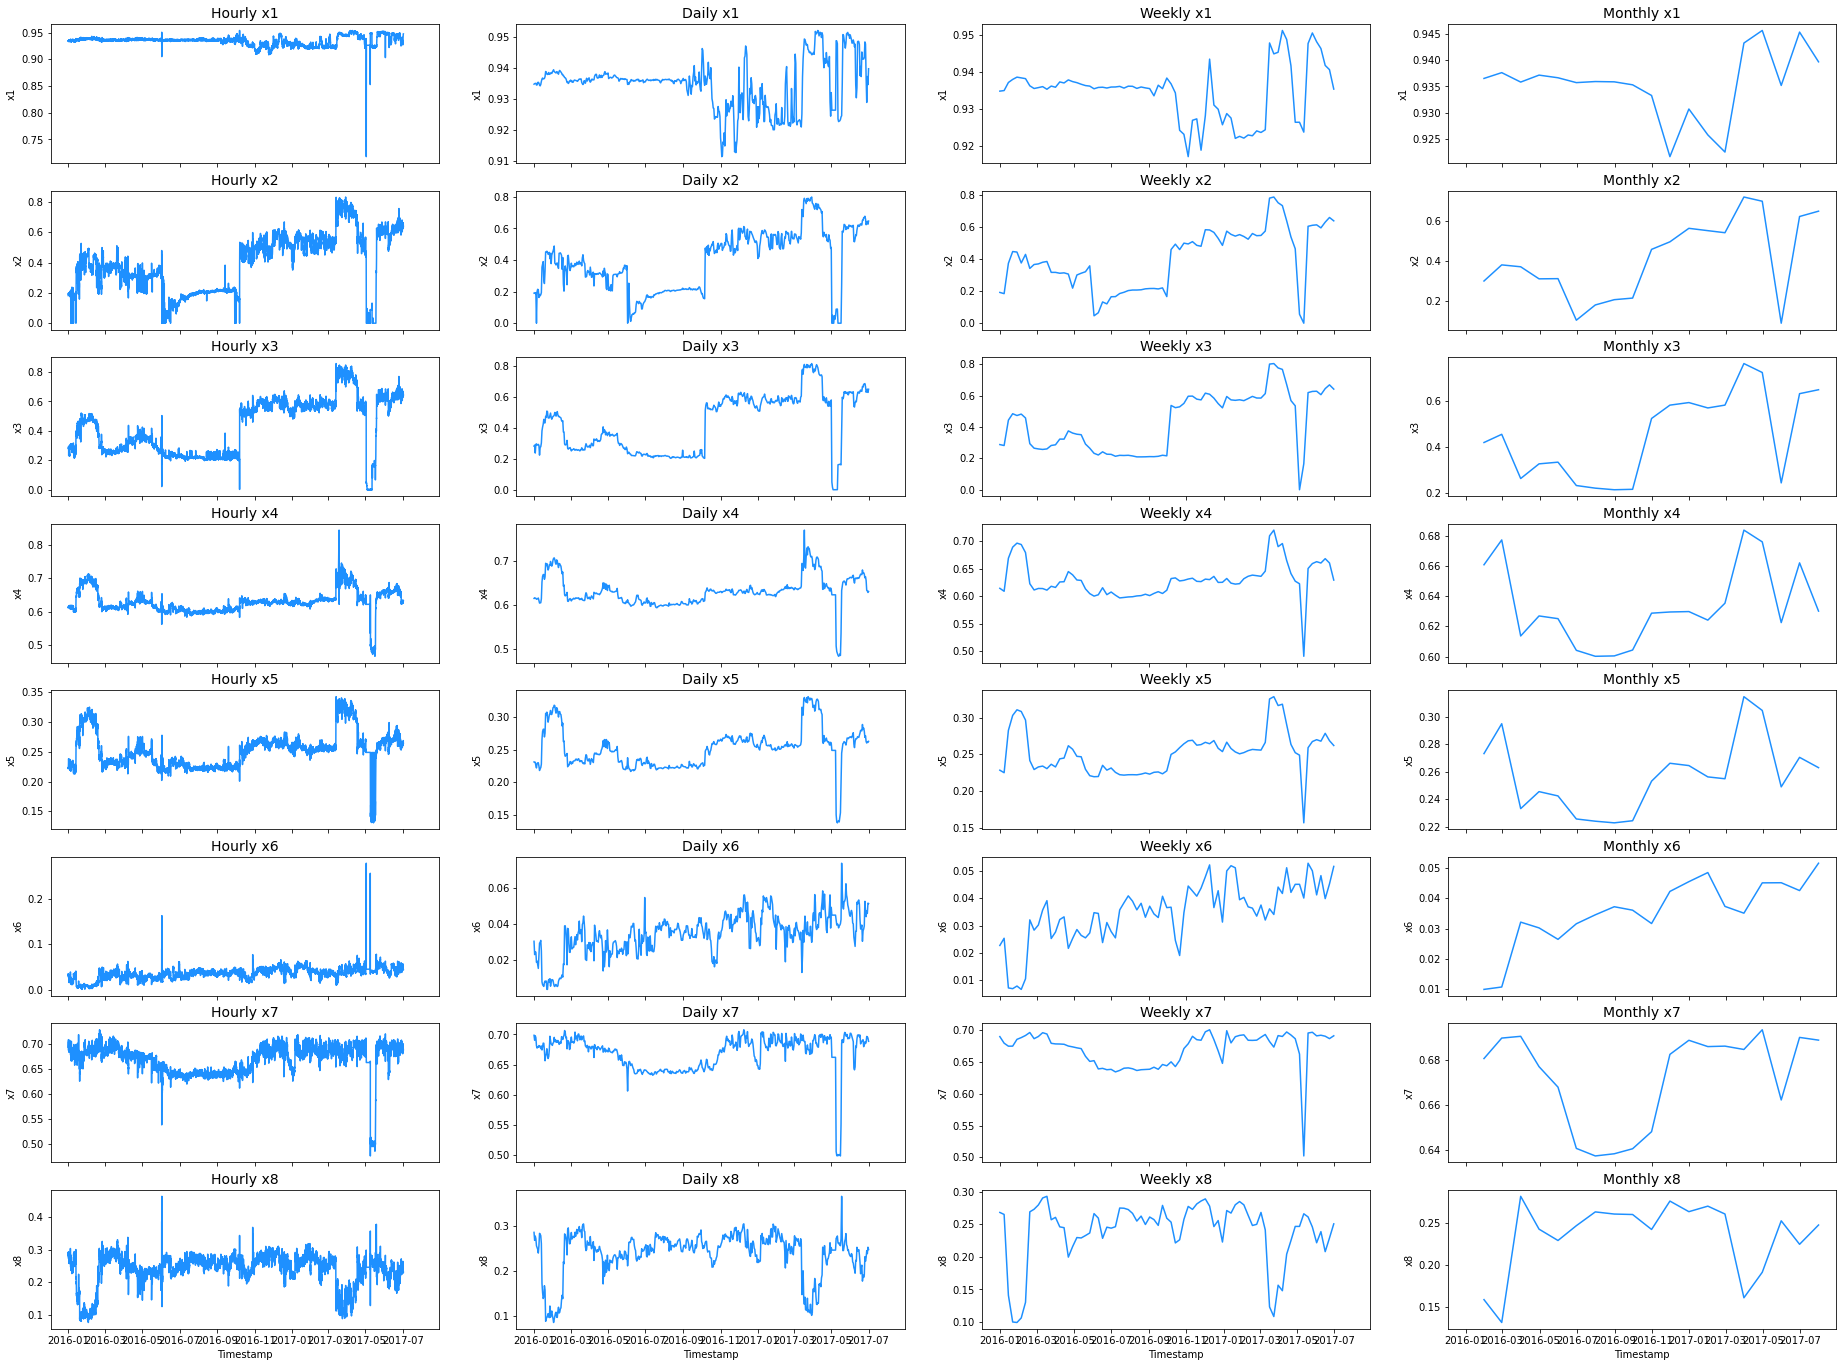

In [8]:
outlier_columns = ['x1', 'x4', 'x5', 'x6', 'x7', 'x8']
df = origin_df.copy()

for col in outlier_columns:
    upper_bound = origin_df[col].median() + 3*origin_df[col].std()
    lower_bound = origin_df[col].median() - 3*origin_df[col].std()
    print("Number of record changed")
    print(df.loc[(origin_df[col] > upper_bound) | (origin_df[col] <lower_bound)].shape)
    df[col] = np.where((origin_df[col] > upper_bound) | (origin_df[col] <lower_bound), origin_df[col].mean(), origin_df[col])

resample(df, x_columns)

<div style="padding:15px;
            background-color:#87b87b">
    - Data still has problem in 2017/05 ==> test for another method of outlier removal: IQR <br>
</div>    

Number of records changed
(10660, 22)
Number of records changed
(16980, 22)
Number of records changed
(8816, 22)
Number of records changed
(6564, 22)
Number of records changed
(4551, 22)
Number of records changed
(18211, 22)


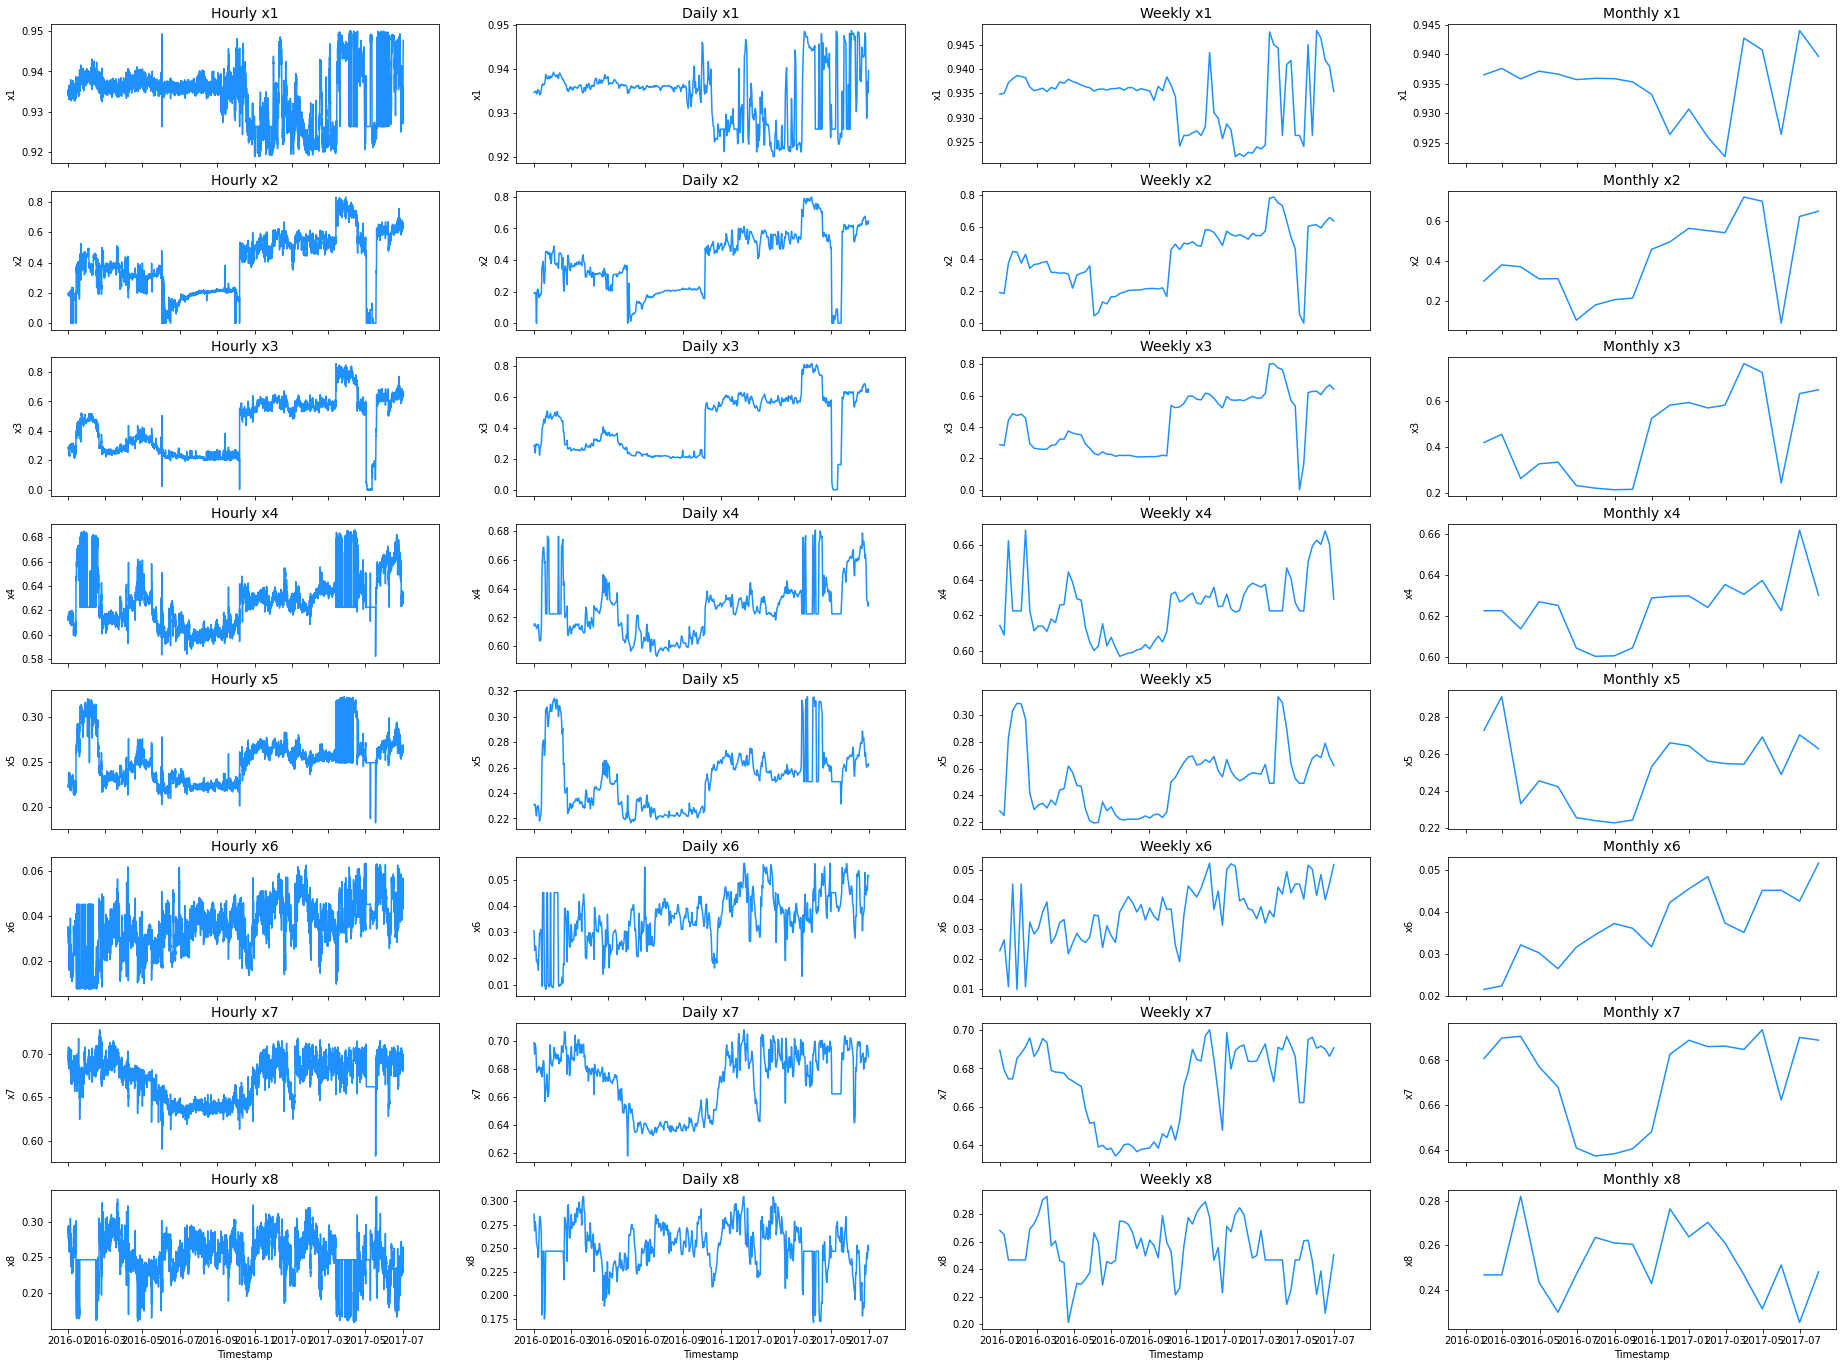

In [9]:
iqr_df = origin_df.copy()

for col in outlier_columns:
    q75, q25 = np.percentile(origin_df[col], [75 ,25])
    iqr_num = q75 - q25
    upper_bound = origin_df[col].quantile(0.75) + 1.5 * iqr_num
    lower_bound = origin_df[col].quantile(0.25) - 1.5 * iqr_num
    print('Number of records changed')
    print(iqr_df.loc[(origin_df[col] > upper_bound) | (origin_df[col] <lower_bound)].shape)
    iqr_df[col] = np.where((origin_df[col] > upper_bound) | (origin_df[col] <lower_bound), origin_df[col].mean(), origin_df[col])

resample(iqr_df, x_columns)

<div style="padding:15px;
            background-color:#87b87b">
    - method IQR make data has less outlier but it changed a significant amount of data <br>
</div>    

<div style="padding:15px;
            background-color:#87b87b">
    - We divide x features into groups: (x2, x3), (x1, x4, x6, x7, x8), (x5, x4) <br>
    - Each further analysis would be performed in representative of that group <br>
</div>    

# Differencing

In [13]:
repr_columns = ['x2', 'x1', 'x5']

In [14]:
for col in repr_columns:
    ts_diff = np.diff(df[col])
    df[col + '_diff_1'] = np.append([0], ts_diff)

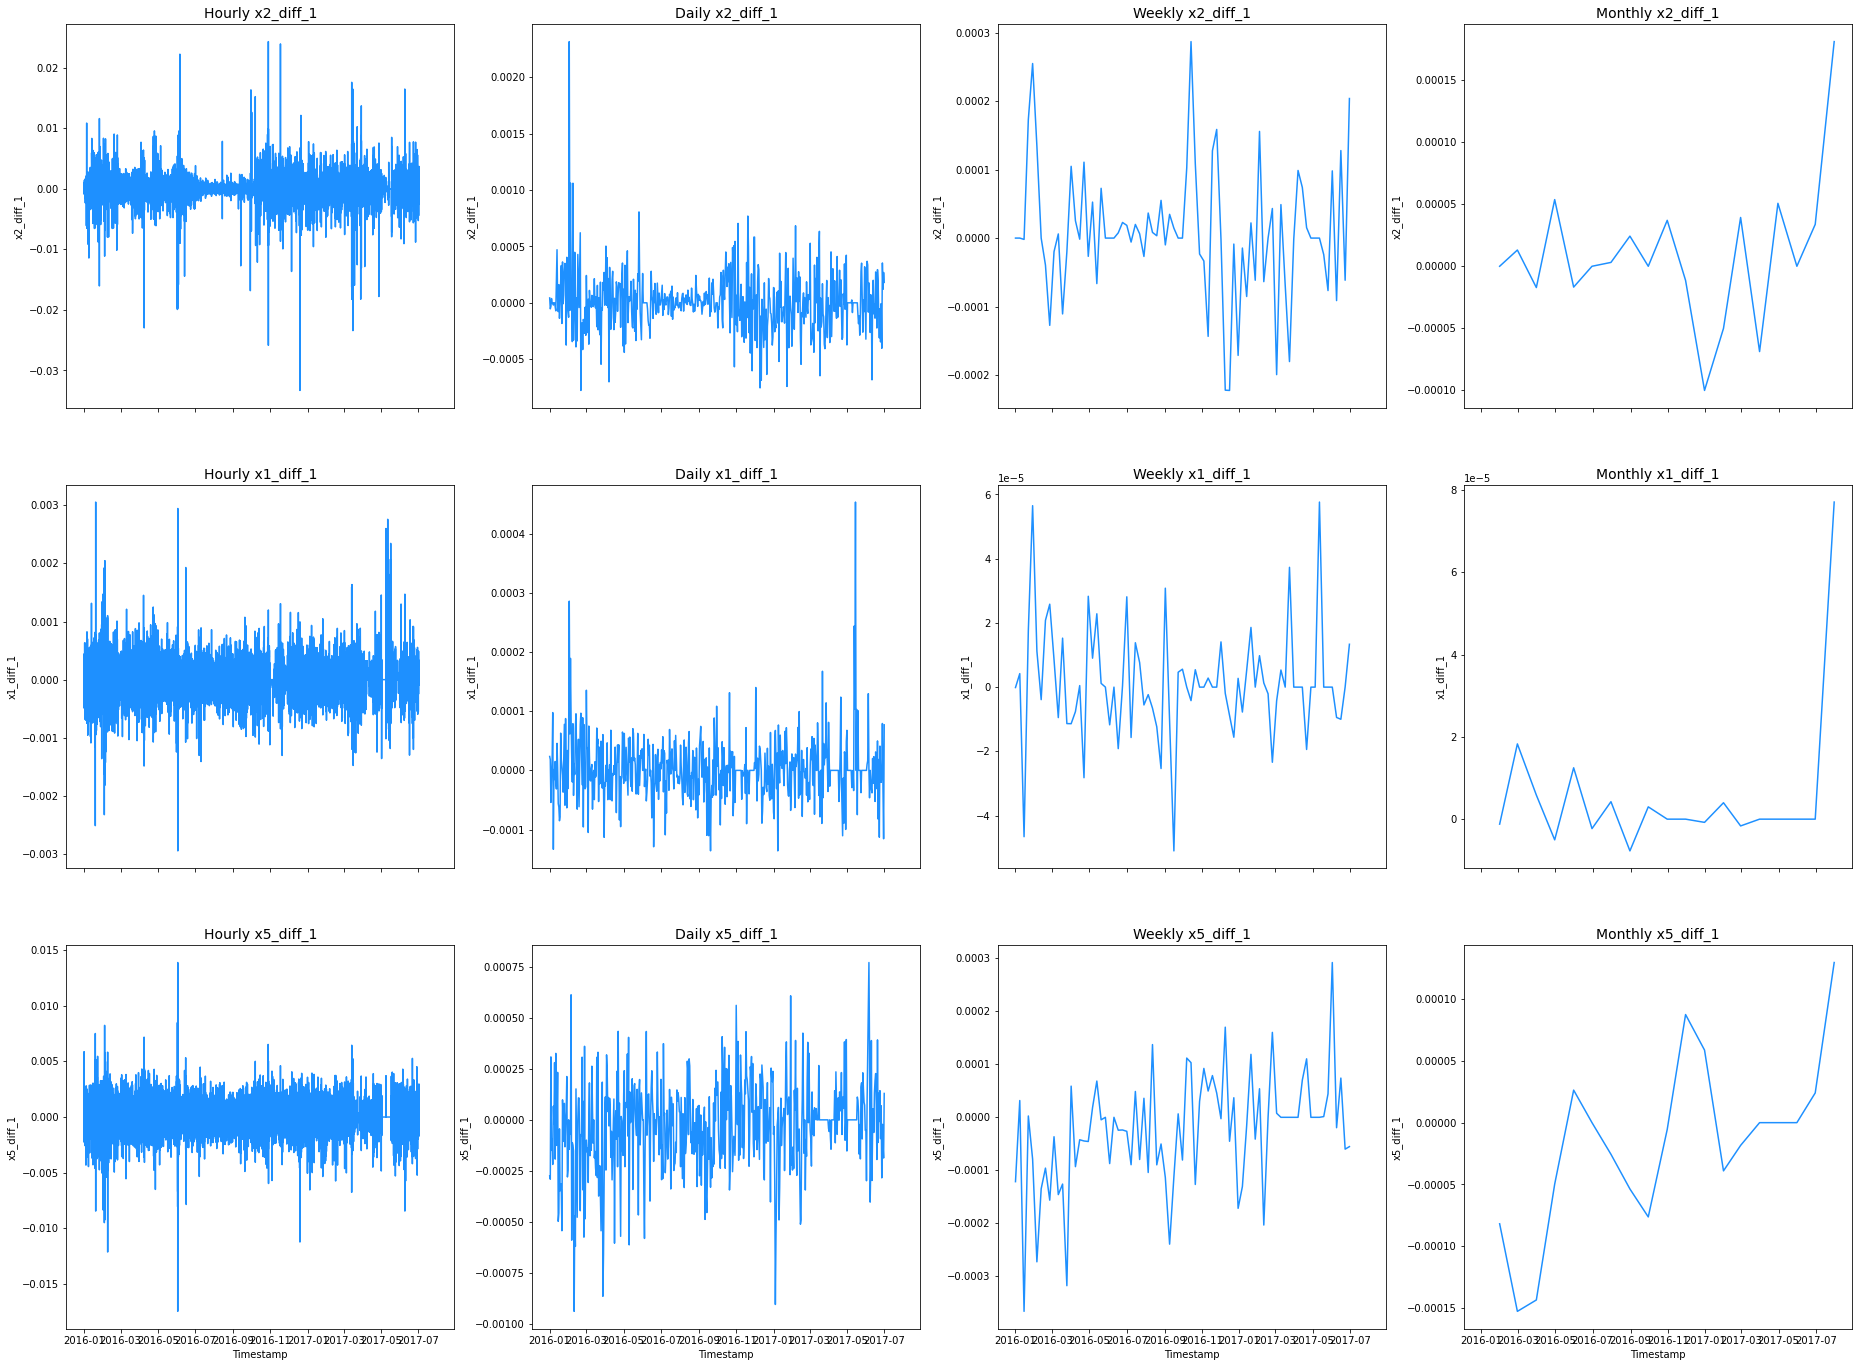

In [11]:
resample(df, ['x2_diff_1', 'x1_diff_1', 'x5_diff_1'])

# Timeseries decomposition

In [46]:
for column in repr_columns:
    decomp = seasonal_decompose(df[column], period=3600, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

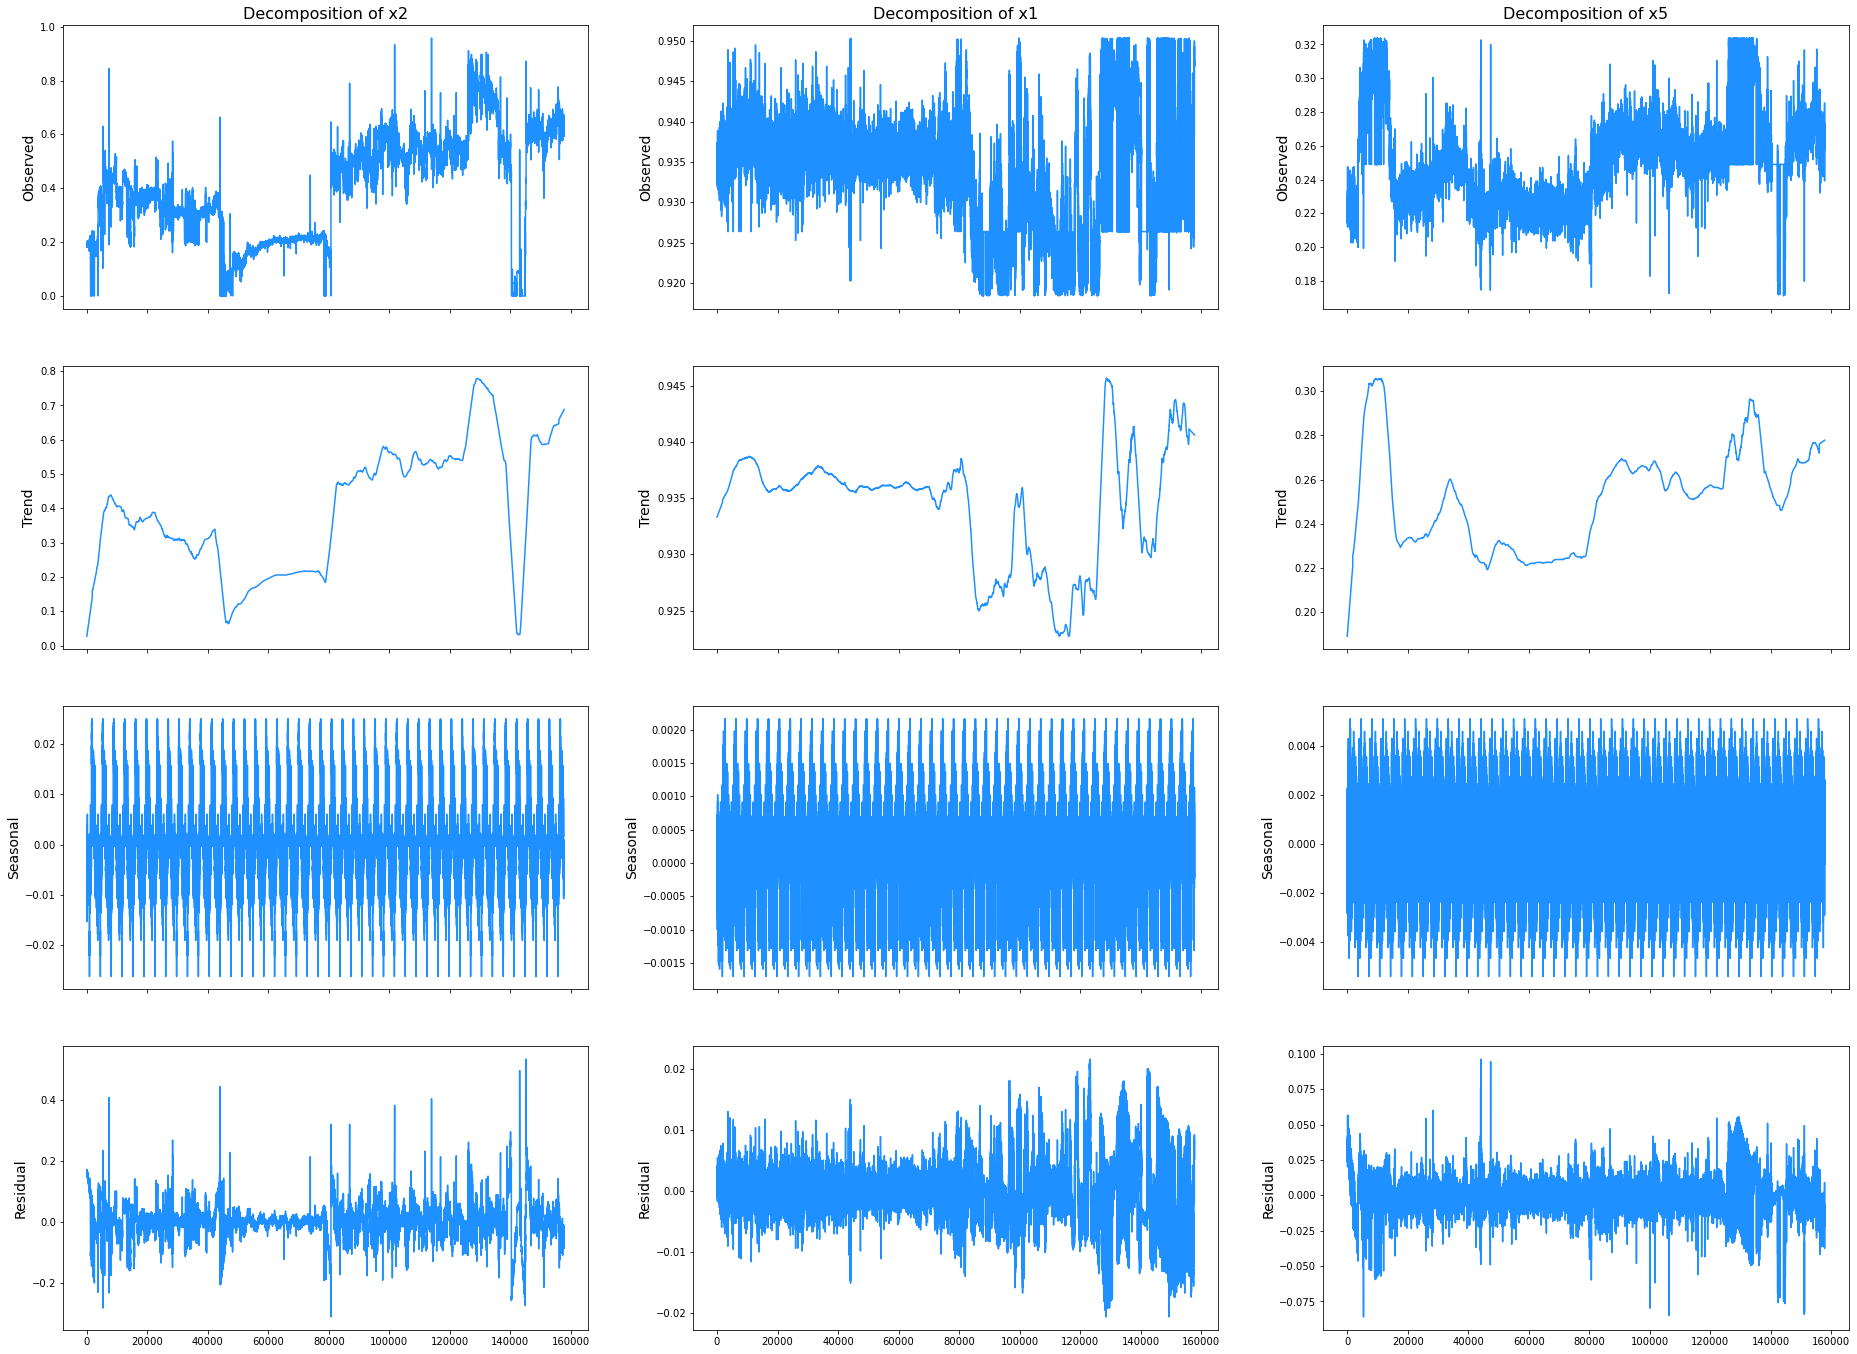

In [52]:
fig, ax = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(32,24))

for i, column in enumerate(repr_columns):
    
    res = seasonal_decompose(df[column], period=3600, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

<div style="padding:15px;
            background-color:#87b87b">
    - The seasonal part does not contribute much <br>
</div>    

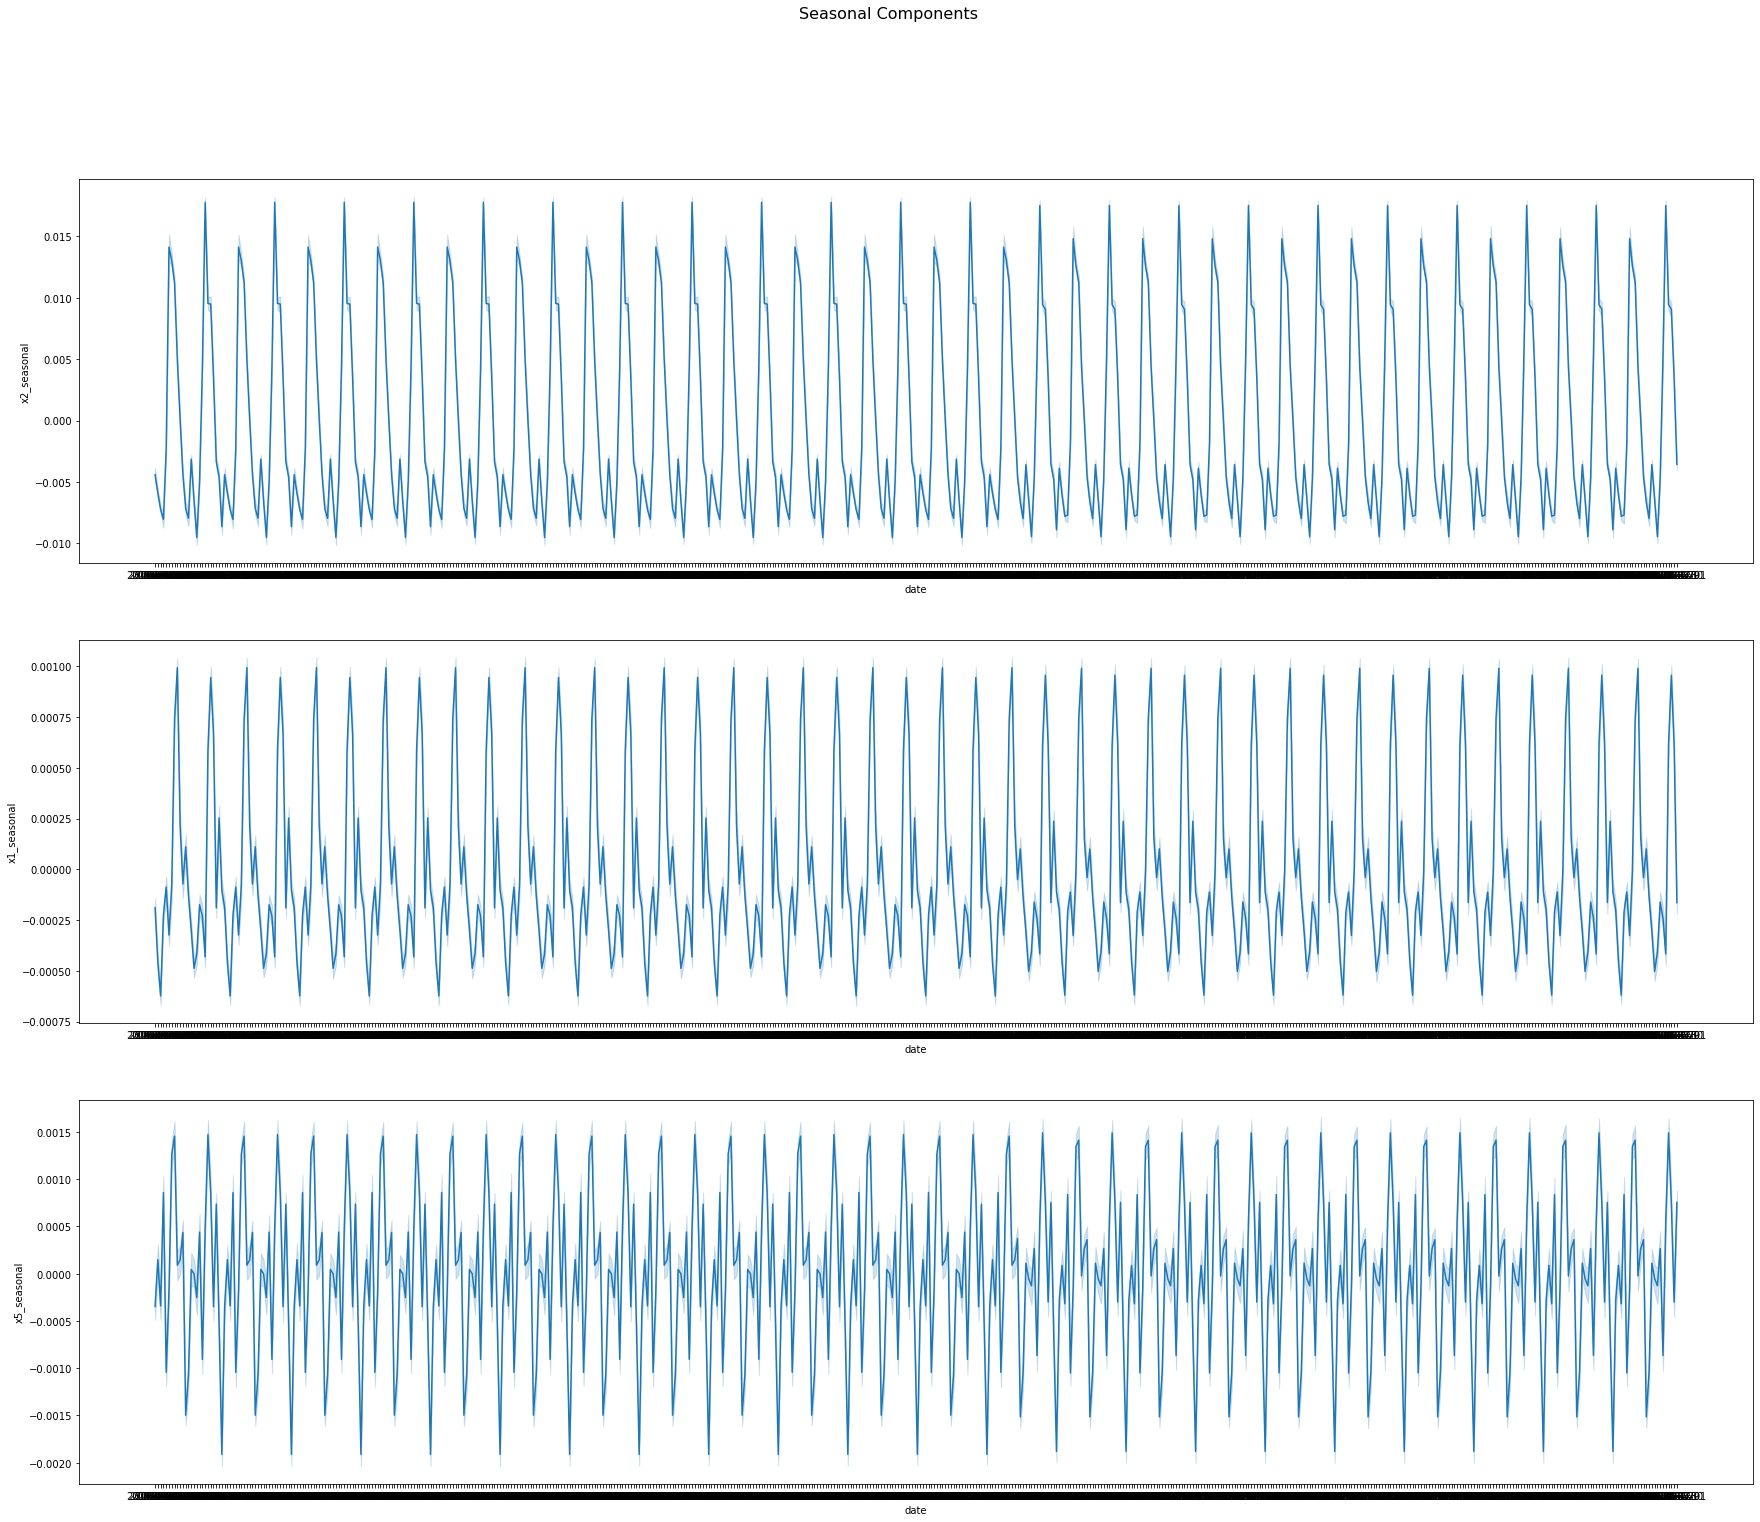

In [55]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(30, 24))
f.suptitle('Seasonal Components', fontsize=16)

for i, column in enumerate(repr_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i])

# feature engineering

<div style="padding:15px;
            background-color:#87b87b">
    - Shift values of variable to see the correlation between lag variable and current variable values <br>
    - I decided to shift to > 14 previous days <br>
</div>    

In [31]:
14*24*12*4

16128

In [34]:
def feature_engineering(df, columns):
    window = 14*24*12

    for column in columns:
        df[f'{column}_shift_5min'] = df[column].shift(1)
        df[f'{column}_shift_1h'] = df[column].shift(1 * 12)
        df[f'{column}_shift_1d'] = df[column].shift(1 * 12 * 24)
        df[f'{column}_shift_1w'] = df[column].shift(1 * 12 * 24 * 7)
        df[f'{column}_shift_14d'] = df[column].shift(1 * window)
        df[f'{column}_shift_28d'] = df[column].shift(2 * window)
        df[f'{column}_shift_1m'] = df[column].shift(1 * 12 * 24 * 7)
        df[f'{column}_shift_42d'] = df[column].shift(3 * window)
        df[f'{column}_shift_56d'] = df[column].shift(4 * window)
    return df

In [36]:
origin_df_fe = feature_engineering(df, columns=x_columns)

In [38]:
generated_features = ['x1_shift_14d',
       'x1_shift_28d', 'x1_shift_42d', 'x2_shift_14d', 'x2_shift_28d',
       'x2_shift_42d', 'x3_shift_14d', 'x3_shift_28d', 'x3_shift_42d',
       'x4_shift_14d', 'x4_shift_28d', 'x4_shift_42d', 'x5_shift_14d',
       'x5_shift_28d', 'x5_shift_42d', 'x6_shift_14d', 'x6_shift_28d',
       'x6_shift_42d', 'x7_shift_14d', 'x7_shift_28d', 'x7_shift_42d',
       'x8_shift_14d', 'x8_shift_28d', 'x8_shift_42d', 'x1_shift_5min',
       'x1_shift_1h', 'x1_shift_1d', 'x1_shift_1w', 'x1_shift_1m',
       'x1_shift_56d', 'x2_shift_5min', 'x2_shift_1h', 'x2_shift_1d',
       'x2_shift_1w', 'x2_shift_1m', 'x2_shift_56d', 'x3_shift_5min',
       'x3_shift_1h', 'x3_shift_1d', 'x3_shift_1w', 'x3_shift_1m',
       'x3_shift_56d', 'x4_shift_5min', 'x4_shift_1h', 'x4_shift_1d',
       'x4_shift_1w', 'x4_shift_1m', 'x4_shift_56d', 'x5_shift_5min',
       'x5_shift_1h', 'x5_shift_1d', 'x5_shift_1w', 'x5_shift_1m',
       'x5_shift_56d', 'x6_shift_5min', 'x6_shift_1h', 'x6_shift_1d',
       'x6_shift_1w', 'x6_shift_1m', 'x6_shift_56d', 'x7_shift_5min',
       'x7_shift_1h', 'x7_shift_1d', 'x7_shift_1w', 'x7_shift_1m',
       'x7_shift_56d', 'x8_shift_5min', 'x8_shift_1h', 'x8_shift_1d',
       'x8_shift_1w', 'x8_shift_1m', 'x8_shift_56d']

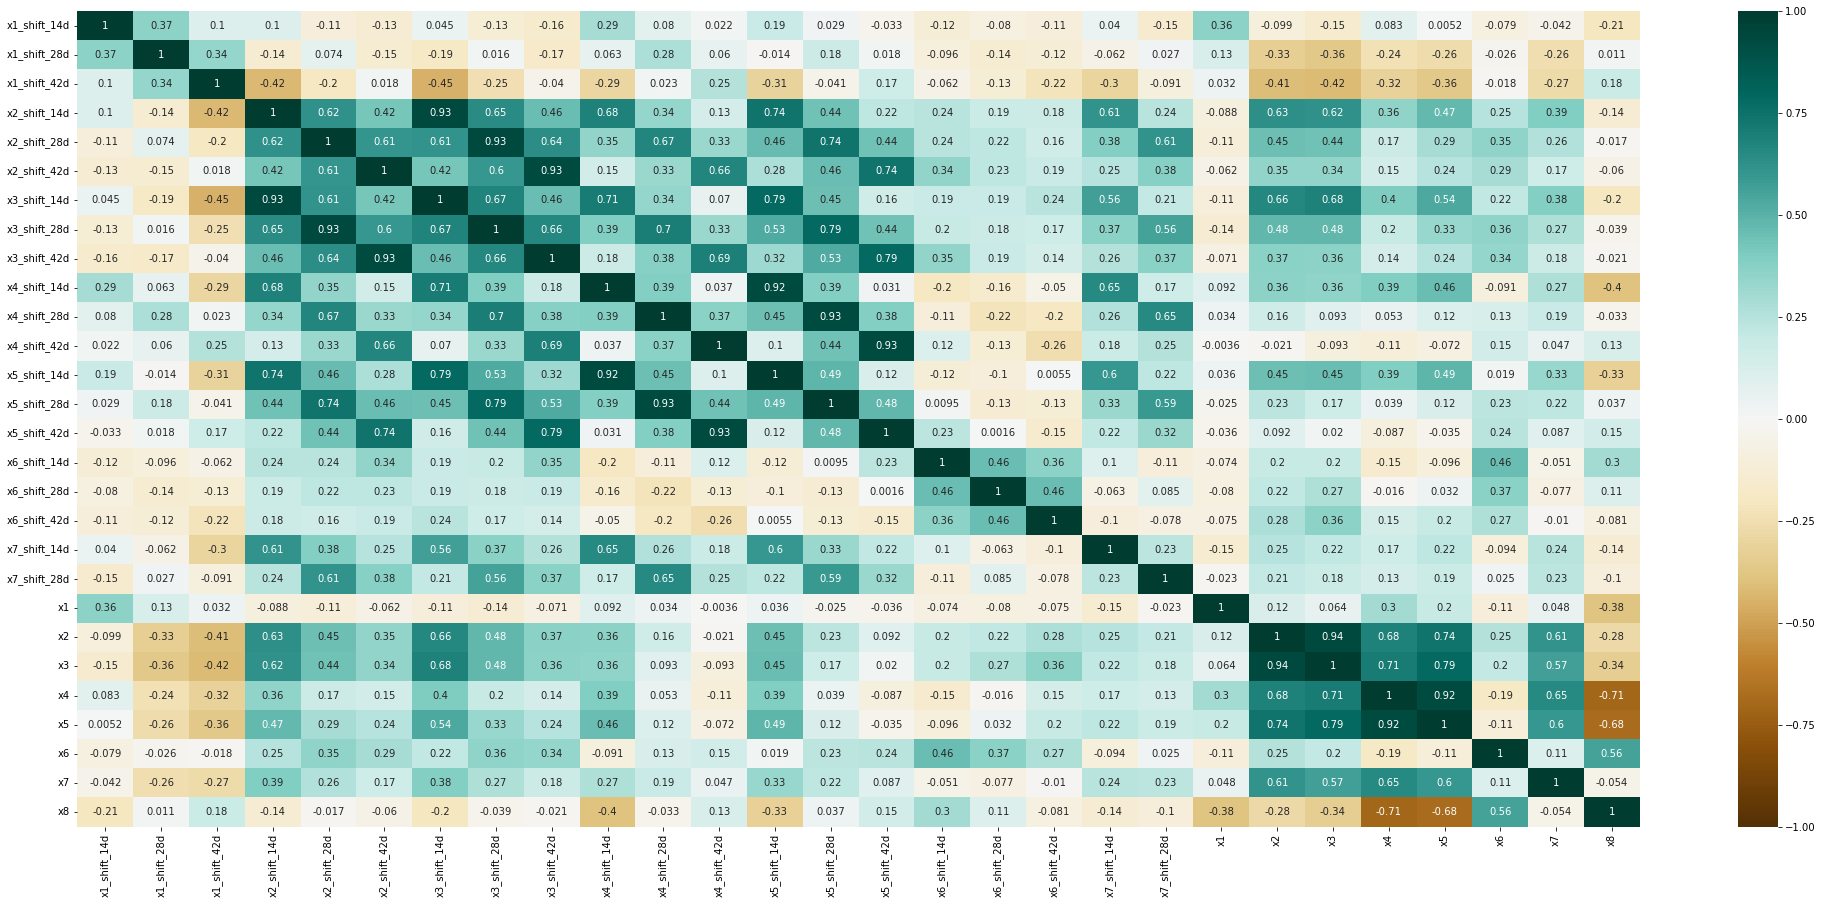

In [40]:
fig, ax = plt.subplots(figsize=(35,15))   
heatmap = sns.heatmap(origin_df_fe[generated_features[:20] + x_columns].corr(), 
                      vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

<div style="padding:15px;
            background-color:#87b87b">
    - There are multiple variable changed by time, so I will use Multivariate timeseries model: Multivariate Prophet to predict one of representative variable (x1, x2, x5) first and continue use that model to predict remaining variable <br>
        
</div>    

In [41]:
origin_df_fe.to_csv('origin_df_fe.csv', header=True, index=False)

In [25]:
df_fe = feature_engineering(df, columns=x_columns)
iqr_df_fe = feature_engineering(iqr_df, columns=x_columns)

df_fe.to_csv('non_outlier_3td_fe.csv', header=True, index=False)
iqr_df_fe.to_csv('iqr_df_fe.csv', header=True, index=False)

In [43]:
df = pd.read_csv('origin_df_fe.csv')

In [44]:
df.shape

(157836, 94)